# Base model

In [16]:
import numpy as np
import tensorflow as tf
import keras
import keras.backend as k
from tensorflow.keras.layers import Conv2D,MaxPooling2D,SpatialDropout2D,Flatten,Dropout,Dense
from tensorflow.keras import Sequential
from tensorflow.keras.models import load_model 
from tensorflow.keras.optimizers import Adam
from tensorflow import image
import cv2
import datetime

In [2]:
model=Sequential()
model.add(Conv2D(32,(3,3),activation='relu',input_shape=(224,224,3)))
model.add(MaxPooling2D() )
model.add(Conv2D(32,(3,3),activation='relu'))
model.add(MaxPooling2D() )
model.add(Conv2D(32,(3,3),activation='relu'))
model.add(MaxPooling2D() )
model.add(Flatten())
model.add(Dense(100,activation='relu'))
model.add(Dense(1,activation='sigmoid'))

In [3]:
model.compile(optimizer='adam',loss='binary_crossentropy',metrics=['accuracy'])

In [4]:
from keras.preprocessing.image import ImageDataGenerator
train_datagen = ImageDataGenerator(
        rescale=1./255,
        shear_range=0.2,
        zoom_range=0.2,
        horizontal_flip=True)

test_datagen = ImageDataGenerator(rescale=1./255)

training_set = train_datagen.flow_from_directory(
        '/content/drive/MyDrive/Colab Notebooks/Mask detection/dataset/train',
        target_size=(224,224),
        batch_size=32 ,
        class_mode='binary')

test_set = test_datagen.flow_from_directory(
        '/content/drive/MyDrive/Colab Notebooks/Mask detection/dataset/val',
        target_size=(224,224),
        batch_size=32,
        class_mode='binary')

Found 3274 images belonging to 2 classes.
Found 818 images belonging to 2 classes.


In [ ]:
from keras.callbacks import ModelCheckpoint
checkpoint = ModelCheckpoint(filepath='/content/drive/MyDrive/Colab Notebooks/Mask detection/models/base_model.h5', 
                               verbose=2, save_best_only=True)
callbacks = [checkpoint]

model_saved=model.fit(
    training_set,
    epochs=10,
    validation_data=test_set,
    verbose = 2,
    callbacks=callbacks
    )

Epoch 1/10


/usr/local/lib/python3.7/dist-packages/PIL/Image.py:960: UserWarning: Palette images with Transparency expressed in bytes should be converted to RGBA images
  "Palette images with Transparency expressed in bytes should be "



Epoch 1: val_loss improved from inf to 0.12934, saving model to /content/drive/MyDrive/Colab Notebooks/Mask detection/models/base_model.h5
103/103 - 54s - loss: 0.0847 - accuracy: 0.9667 - val_loss: 0.1293 - val_accuracy: 0.9584 - 54s/epoch - 523ms/step
Epoch 2/10

Epoch 2: val_loss improved from 0.12934 to 0.09187, saving model to /content/drive/MyDrive/Colab Notebooks/Mask detection/models/base_model.h5
103/103 - 55s - loss: 0.1002 - accuracy: 0.9618 - val_loss: 0.0919 - val_accuracy: 0.9597 - 55s/epoch - 538ms/step
Epoch 3/10

Epoch 3: val_loss did not improve from 0.09187
103/103 - 55s - loss: 0.0779 - accuracy: 0.9725 - val_loss: 0.1085 - val_accuracy: 0.9548 - 55s/epoch - 534ms/step
Epoch 4/10

Epoch 4: val_loss did not improve from 0.09187
103/103 - 53s - loss: 0.0713 - accuracy: 0.9734 - val_loss: 0.1101 - val_accuracy: 0.9658 - 53s/epoch - 518ms/step
Epoch 5/10

Epoch 5: val_loss did not improve from 0.09187
103/103 - 54s - loss: 0.0763 - accuracy: 0.9713 - val_loss: 0.0986 -

# mobilenet_v2

In [19]:
# import the necessary packages
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.applications import MobileNetV2
from tensorflow.keras.layers import AveragePooling2D
from tensorflow.keras.layers import Dropout
from tensorflow.keras.layers import Flatten
from tensorflow.keras.layers import Dense
from tensorflow.keras.layers import Input
from tensorflow.keras.models import Model
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.applications.mobilenet_v2 import preprocess_input
from tensorflow.keras.preprocessing.image import img_to_array
from tensorflow.keras.preprocessing.image import load_img
from tensorflow.keras.utils import to_categorical
from sklearn.preprocessing import LabelBinarizer
from sklearn.model_selection import train_test_split
from sklearn.metrics import classification_report
from imutils import paths
import matplotlib.pyplot as plt
import numpy as np
import os

In [30]:
# initialize the initial learning rate, number of epochs to train for,
# and batch size
INIT_LR = 1e-4
EPOCHS = 10
BS = 32

In [21]:
DIRECTORY = r"/content/drive/MyDrive/Colab Notebooks/Mask detection/dataset"
CATEGORIES = ["with_mask", "without_mask"]

In [22]:
print("[INFO] loading images...")

data = []
labels = []

for category in CATEGORIES:
    path = os.path.join(DIRECTORY, category)
    for img in os.listdir(path):
        img_path = os.path.join(path, img)
        image = load_img(img_path, target_size=(224, 224))
        image = img_to_array(image)
        image = preprocess_input(image)

        data.append(image)
        labels.append(category)

# perform one-hot encoding on the labels
lb = LabelBinarizer()
labels = lb.fit_transform(labels)
labels = to_categorical(labels)

data = np.array(data, dtype="float32")
labels = np.array(labels)

(trainX, testX, trainY, testY) = train_test_split(data, labels,
                                                  test_size=0.20, stratify=labels, random_state=42)

[INFO] loading images...


/usr/local/lib/python3.7/dist-packages/PIL/Image.py:960: UserWarning: Palette images with Transparency expressed in bytes should be converted to RGBA images
  "Palette images with Transparency expressed in bytes should be "


In [23]:
aug = ImageDataGenerator(
    rotation_range=20,
    zoom_range=0.15,
    width_shift_range=0.2,
    height_shift_range=0.2,
    shear_range=0.15,
    horizontal_flip=True,
    fill_mode="nearest")

In [24]:
# load the MobileNetV2 network, ensuring the head FC layer sets are
# left off
baseModel = MobileNetV2(weights="imagenet", include_top=False,
    input_tensor=Input(shape=(224, 224, 3)))

In [25]:
# construct the head of the model that will be placed on top of the
# the base model
headModel = baseModel.output
headModel = AveragePooling2D(pool_size=(7, 7))(headModel)
headModel = Flatten(name="flatten")(headModel)
headModel = Dense(128, activation="relu")(headModel)
headModel = Dropout(0.5)(headModel)
headModel = Dense(2, activation="softmax")(headModel)

In [26]:
# place the head FC model on top of the base model (this will become
# the actual model we will train)
model = Model(inputs=baseModel.input, outputs=headModel)

In [27]:
# loop over all layers in the base model and freeze them so they will
# *not* be updated during the first training process
for layer in baseModel.layers:
    layer.trainable = False

In [29]:
# compile our model
print("[INFO] compiling model...")
opt = Adam(learning_rate=INIT_LR, decay=INIT_LR / EPOCHS)
model.compile(loss="binary_crossentropy", optimizer=opt,
              metrics=["accuracy"])

[INFO] compiling model...


In [32]:
# train the head of the network
print("[INFO] training head...")
H = model.fit(
    aug.flow(trainX, trainY, batch_size=BS),
    steps_per_epoch=len(trainX) // BS,
    validation_data=(testX, testY),
    validation_steps=len(testX) // BS,
    epochs=EPOCHS,
    verbose = 2)

[INFO] training head...
Epoch 1/10
102/102 - 47s - loss: 0.2844 - accuracy: 0.9239 - val_loss: 0.1407 - val_accuracy: 0.9707 - 47s/epoch - 463ms/step
Epoch 2/10
102/102 - 35s - loss: 0.1348 - accuracy: 0.9652 - val_loss: 0.1021 - val_accuracy: 0.9719 - 35s/epoch - 344ms/step
Epoch 3/10
102/102 - 35s - loss: 0.0979 - accuracy: 0.9750 - val_loss: 0.0792 - val_accuracy: 0.9719 - 35s/epoch - 344ms/step
Epoch 4/10
102/102 - 44s - loss: 0.0771 - accuracy: 0.9763 - val_loss: 0.0746 - val_accuracy: 0.9719 - 44s/epoch - 432ms/step
Epoch 5/10
102/102 - 35s - loss: 0.0695 - accuracy: 0.9809 - val_loss: 0.0719 - val_accuracy: 0.9731 - 35s/epoch - 347ms/step
Epoch 6/10
102/102 - 36s - loss: 0.0658 - accuracy: 0.9827 - val_loss: 0.0597 - val_accuracy: 0.9805 - 36s/epoch - 351ms/step
Epoch 7/10
102/102 - 35s - loss: 0.0627 - accuracy: 0.9812 - val_loss: 0.0676 - val_accuracy: 0.9731 - 35s/epoch - 344ms/step
Epoch 8/10
102/102 - 37s - loss: 0.0482 - accuracy: 0.9861 - val_loss: 0.0673 - val_accuracy: 

In [33]:
# make predictions on the testing set
print("[INFO] evaluating network...")
predIdxs = model.predict(testX, batch_size=BS)

[INFO] evaluating network...


In [34]:
predIdxs = np.argmax(predIdxs, axis=1)

In [35]:
# show a nicely formatted classification report
print(classification_report(testY.argmax(axis=1), predIdxs,
    target_names=lb.classes_))

              precision    recall  f1-score   support

   with_mask       0.96      1.00      0.98       433
without_mask       0.99      0.95      0.97       386

    accuracy                           0.98       819
   macro avg       0.98      0.97      0.98       819
weighted avg       0.98      0.98      0.98       819



In [37]:
# serialize the model to disk
print("[INFO] saving mask detector model...")
model.save("/content/drive/MyDrive/Colab Notebooks/Mask detection/models/mobilenet_v2.model", save_format="h5")

[INFO] saving mask detector model...


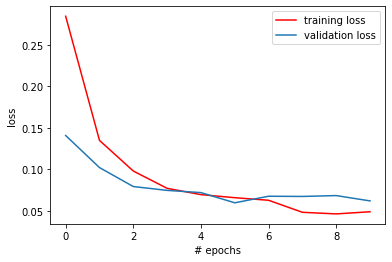

In [38]:
from matplotlib import pyplot as plt

plt.plot(H.history['loss'],'r',label='training loss')
plt.plot(H.history['val_loss'],label='validation loss')
plt.xlabel('# epochs')
plt.ylabel('loss')
plt.legend()
plt.show()

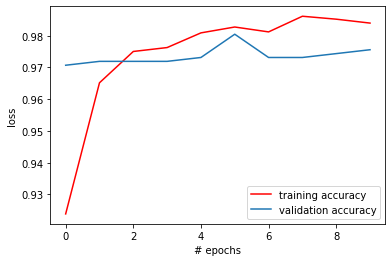

In [39]:
plt.plot(H.history['accuracy'],'r',label='training accuracy')
plt.plot(H.history['val_accuracy'],label='validation accuracy')
plt.xlabel('# epochs')
plt.ylabel('loss')
plt.legend()
plt.show()

# VGG19

In [43]:
from tensorflow.keras.applications.vgg19 import VGG19
from tensorflow.keras.applications.vgg19 import preprocess_input

In [44]:
# load the MobileNetV2 network, ensuring the head FC layer sets are
# left off
baseModel = VGG19(weights="imagenet", include_top=False, input_tensor=Input(shape=(224, 224, 3)))

80150528/80134624 [==============================] - 0s 0us/step


In [45]:
# construct the head of the model that will be placed on top of the
# the base model
headModel = baseModel.output
headModel = AveragePooling2D(pool_size=(7, 7))(headModel)
headModel = Flatten(name="flatten")(headModel)
headModel = Dense(128, activation="relu")(headModel)
headModel = Dropout(0.5)(headModel)
headModel = Dense(2, activation="softmax")(headModel)

In [46]:
# place the head FC model on top of the base model (this will become
# the actual model we will train)
model = Model(inputs=baseModel.input, outputs=headModel)

In [47]:
# loop over all layers in the base model and freeze them so they will
# *not* be updated during the first training process
for layer in baseModel.layers:
    layer.trainable = False

In [48]:
# compile our model
print("[INFO] compiling model...")
opt = Adam(learning_rate=INIT_LR, decay=INIT_LR / EPOCHS)
model.compile(loss="binary_crossentropy", optimizer=opt,
    metrics=["accuracy"])

[INFO] compiling model...


In [ ]:
model.summary()

In [50]:
# train the head of the network
print("[INFO] training head...")
H = model.fit(
    aug.flow(trainX, trainY, batch_size=BS),
    steps_per_epoch=len(trainX) // BS,
    validation_data=(testX, testY),
    validation_steps=len(testX) // BS,
    epochs=EPOCHS,
  verbose = 2)

[INFO] training head...
Epoch 1/10
102/102 - 59s - loss: 0.6838 - accuracy: 0.5999 - val_loss: 0.6024 - val_accuracy: 0.8559 - 59s/epoch - 578ms/step
Epoch 2/10
102/102 - 46s - loss: 0.6084 - accuracy: 0.7096 - val_loss: 0.5294 - val_accuracy: 0.9304 - 46s/epoch - 454ms/step
Epoch 3/10
102/102 - 46s - loss: 0.5350 - accuracy: 0.8258 - val_loss: 0.4570 - val_accuracy: 0.9341 - 46s/epoch - 451ms/step
Epoch 4/10
102/102 - 45s - loss: 0.4676 - accuracy: 0.8844 - val_loss: 0.3925 - val_accuracy: 0.9377 - 45s/epoch - 445ms/step
Epoch 5/10
102/102 - 45s - loss: 0.4181 - accuracy: 0.8961 - val_loss: 0.3381 - val_accuracy: 0.9438 - 45s/epoch - 445ms/step
Epoch 6/10
102/102 - 45s - loss: 0.3680 - accuracy: 0.9192 - val_loss: 0.2951 - val_accuracy: 0.9499 - 45s/epoch - 442ms/step
Epoch 7/10
102/102 - 45s - loss: 0.3290 - accuracy: 0.9245 - val_loss: 0.2643 - val_accuracy: 0.9585 - 45s/epoch - 444ms/step
Epoch 8/10
102/102 - 45s - loss: 0.3009 - accuracy: 0.9260 - val_loss: 0.2372 - val_accuracy: 

In [51]:
# make predictions on the testing set
print("[INFO] evaluating network...")
predIdxs = model.predict(testX, batch_size=BS)

[INFO] evaluating network...


In [52]:
predIdxs = np.argmax(predIdxs, axis=1)

In [53]:
# show a nicely formatted classification report
print(classification_report(testY.argmax(axis=1), predIdxs,
    target_names=lb.classes_))

              precision    recall  f1-score   support

   with_mask       0.97      0.95      0.96       433
without_mask       0.94      0.97      0.95       386

    accuracy                           0.96       819
   macro avg       0.96      0.96      0.96       819
weighted avg       0.96      0.96      0.96       819



In [54]:
# serialize the model to disk
print("[INFO] saving mask detector model...")
model.save("/content/drive/MyDrive/Colab Notebooks/Mask detection/models/VGG19.model", save_format="h5")

[INFO] saving mask detector model...
